In [15]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------
# custom packages
import models.aux_funs as maf
from models.unet import UNet
from models.segnet import SegNet
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud

import torchmetrics as TM
import matplotlib.pyplot as plt
from train import print_test_dataset_masks
import os
import pickle
import torch

# Fix the random seed

In [16]:
random_seed = 0
cf.seed_torch(random_seed)

# Configure the experiment

In [17]:
conf_args = {
    # optimizer
    'delta':1.0, 'lr':0.005, 'lamda_0':0.01, 'lamda_1':0.001, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.9,
    # initialization
    'sparse_init':0.1, 'r':[5.,5., 5.],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

# Initiate the model

In [18]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model =UNet(n_channels=3, n_classes=3)
# best_model = train.best_model(mnist_conv(**model_kwargs).to(conf.device))

# Weight initialization

In [19]:

def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0, conf.r[0], ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[2], ltype=torch.nn.Conv2d)
    maf.sparsify_(model, conf.sparse_init, ltype=nn.Conv2d, conv_group=conf.conv_group)
    return model


# Initialize the weights
model = init_weights(conf, model)

print('net_sparse', maf.net_sparsity(model))
print('node_sparse:', maf.node_sparsity(model))


net_sparse 0.09510327732158719
node_sparse: [0.25, 0.8125, 0.75, 0.9375, 0.96875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 1.0, 1.0, 0.8125, 0.6666666666666666]


# Optimizer

In [20]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l1_l2_conv(lamda0=conf.lamda_0, lamda1=conf.lamda_1)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta, weight_decay=conf.lamda_1)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])            
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2,'delta':conf.delta},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1),'delta':conf.delta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=10,threshold=0.0001)
    
    return opt, scheduler

# Dataset

In [21]:
import torchvision
import os
working_dir = "data"
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

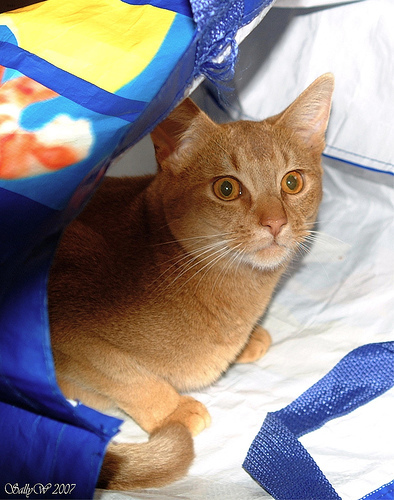

In [22]:
(train_pets_input, train_pets_target) = pets_train_orig[0]
# Spot check an input image.
train_pets_input

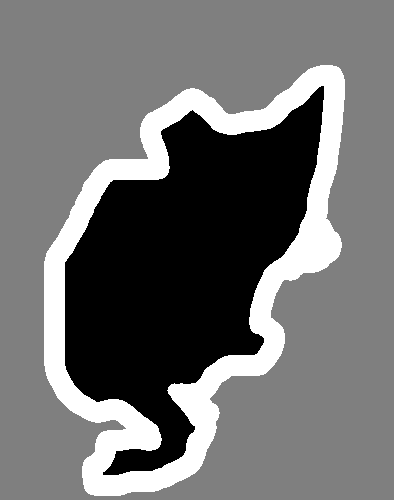

In [23]:
import torchvision.transforms as T
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

t2img(trimap2f(train_pets_target))

In [24]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if
        
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)
    
    

In [25]:
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
import torch

# Assume that OxfordIIITPetsAugmented is a dataset class that you have implemented
# and pets_path_train, pets_path_test are the paths to the dataset.

# Define a function to transform the target tensor
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

# Define a function to convert arguments to a dictionary
def args_to_dict(**kwargs):
    return kwargs

# Define the transformation dictionary
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        T.Resize((16, 16), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.),
    ]),
    post_transform=T.Compose([
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train, validation, and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be changed. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

batch_size_train = 1
batch_size_valid = 1
batch_size_test = 1

num_samples_train = 10 * batch_size_train
num_samples_valid = 1 * batch_size_valid
num_samples_test = 1 * batch_size_test

# Create subsets of the datasets
train_subset = Subset(pets_train, range(num_samples_train))
valid_subset = Subset(pets_train, range(num_samples_train, num_samples_train+num_samples_valid))
test_subset = Subset(pets_test, range(num_samples_test))

# Create data loaders for the subsets
pets_train_loader = DataLoader(
    train_subset,
    batch_size=batch_size_train,
    shuffle=True,
)

pets_valid_loader = DataLoader(
    valid_subset,
    batch_size=batch_size_valid,
    shuffle=True,
)

pets_test_loader = DataLoader(
    test_subset,
    batch_size=batch_size_test,
    shuffle=True,
)

# Retrieve a batch of data from the loaders for checking
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(valid_pets_inputs, valid_pets_targets) = next(iter(pets_valid_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))

train_pets_inputs.shape, train_pets_targets.shape, valid_pets_inputs.shape, valid_pets_targets.shape, test_pets_inputs.shape, test_pets_targets.shape




(torch.Size([1, 3, 16, 16]),
 torch.Size([1, 1, 16, 16]),
 torch.Size([1, 3, 16, 16]),
 torch.Size([1, 1, 16, 16]),
 torch.Size([1, 3, 16, 16]),
 torch.Size([1, 1, 16, 16]))

In [26]:
# Count the number of batches in the train DataLoader
num_batches_train = 0
for _ in pets_train_loader:
    num_batches_train += 1

print(f"Number of batches in the train DataLoader: {num_batches_train}")

# Count the number of batches in the test DataLoader
num_batches_valid = 0
for _ in pets_valid_loader:
    num_batches_valid += 1

print(f"Number of batches in the test DataLoader: {num_batches_valid}")


Number of batches in the train DataLoader: 10
Number of batches in the test DataLoader: 1


Epoch: 00, IoU: 0.0000, Net: 0.0951, Node: 0.2500, 0.8125, 0.7500, 0.9375, 0.9688, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 1.0000, 1.0000, 0.8125, 0.6667


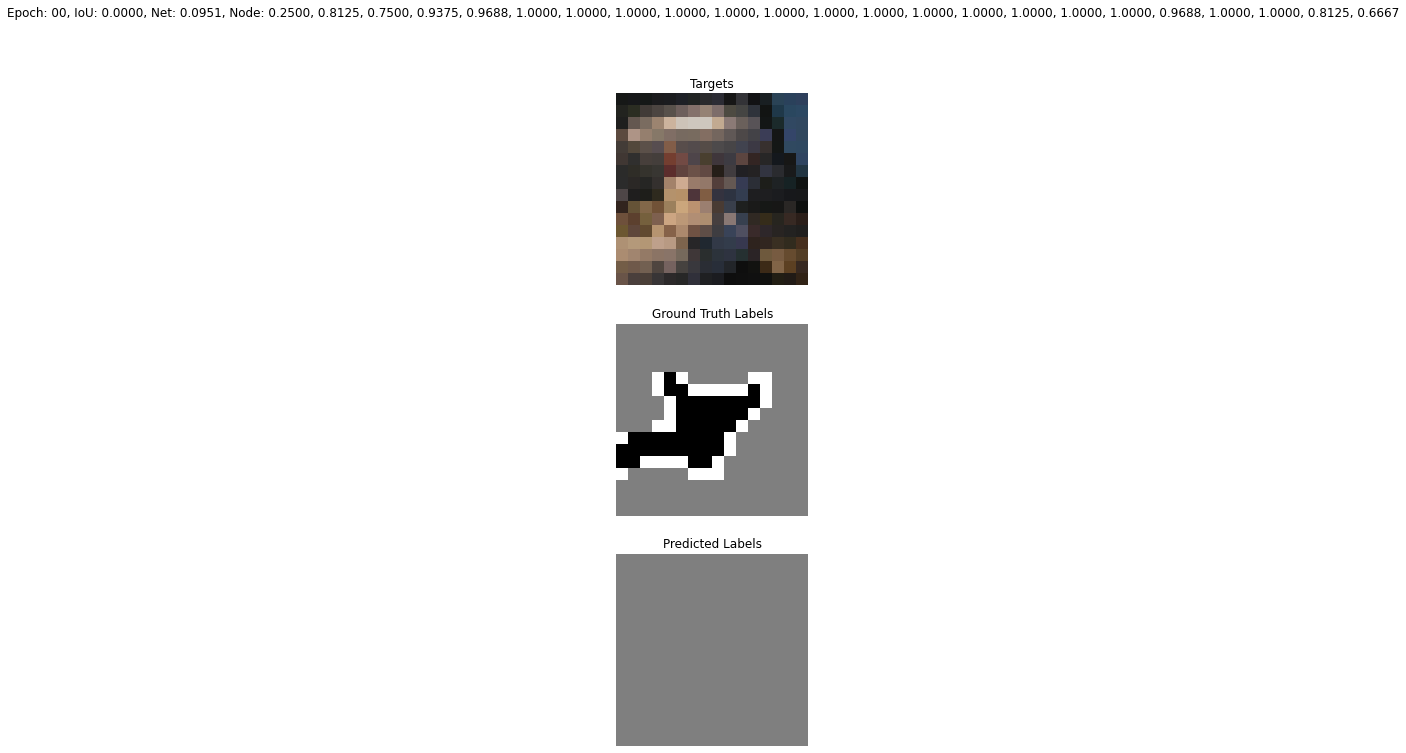

Epoch: 00, IoU: 0.0000, Net: 0.0951, Node: 0.2500, 0.8125, 0.7500, 0.9375, 0.9688, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 1.0000, 1.0000, 0.8125, 0.6667


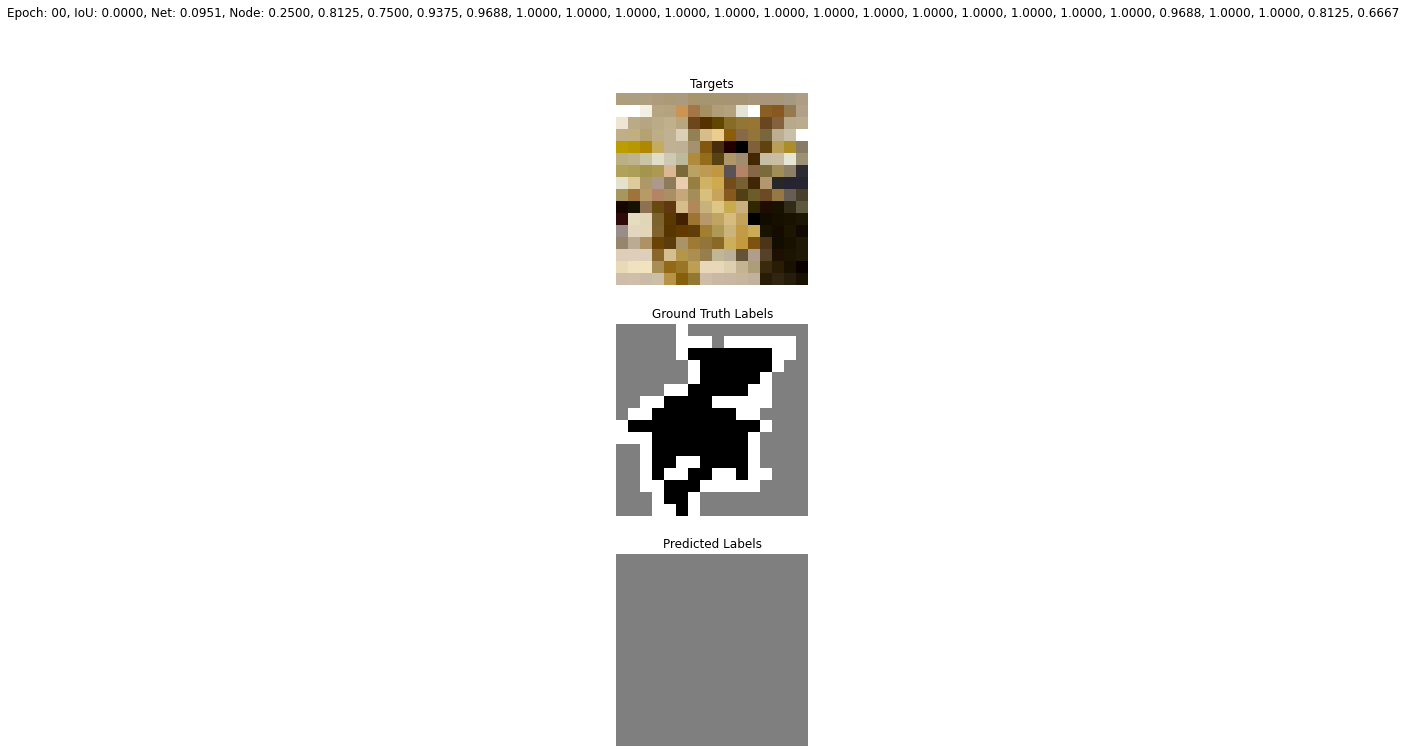

In [27]:
save_path = os.path.join(working_dir, "training_result")
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(model, valid_pets_inputs, valid_pets_targets, epoch=0, save_path=None, show_plot=True)
print_test_dataset_masks(model, train_pets_inputs, train_pets_targets, epoch=0, save_path=None, show_plot=True)

# History and Runs

# Training

In [32]:
import os
import csv
import pickle
import torch
import matplotlib.pyplot as plt

# Initialize the optimizer and scheduler
opt, scheduler = init_opt(conf, model)

# Format the learning rate into a string suitable for directory naming
formatted_lr = f"lr_{conf.lr}"
formatted_lamda0=f"l0_{conf.lamda_0}"
formatted_lamda1=f"l1_{conf.lamda_1}"
formatted_opt=f"{conf.optim}"
# Incorporate the learning rate into the save path
save_path = os.path.join('testresult', f"{formatted_lr}_{formatted_lamda0}_{formatted_lamda1}_{formatted_opt}")

def save_validation_results(epoch, val_data, save_path):
    # Create the directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Define the file paths with the learning rate included
    iou_path = os.path.join(save_path, f"iou_accuracy.csv")
    dice_path = os.path.join(save_path, f"dice_accuracy.csv")
    net_sparsity_path = os.path.join(save_path, f"net_sparsity.csv")
    node_sparsity_path = os.path.join(save_path, f"node_sparsity.csv")
    loss_path = os.path.join(save_path, f"validation_loss.csv")

    # Helper function to write to a CSV file
    def write_csv(file_path, epoch, value):
        file_exists = os.path.isfile(file_path)
        with open(file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(["Epoch", "Value"])
            writer.writerow([epoch, value])

    # Save the IOU accuracy
    write_csv(iou_path, epoch, val_data['IOU Accuracy'])

    # Save the Dice accuracy
    write_csv(dice_path, epoch, val_data['Dice Accuracy'])

    # Save the Net Sparsity
    write_csv(net_sparsity_path, epoch, val_data['Net Sparsity'])

    # Save the Node Sparsity
    with open(node_sparsity_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        file_exists = os.path.isfile(node_sparsity_path)
        if not file_exists:
            headers = ["Epoch"] + [f"Node_{i}" for i in range(len(val_data['Node'].split(", ")))]
            writer.writerow(headers)
        row = [epoch] + [float(value) for value in val_data['Node'].split(", ")]
        writer.writerow(row)

    # Save the validation loss
    write_csv(loss_path, epoch, val_data['loss'])

# Now modify the train_loop function to call save_validation_results after each validation step
def train_loop(model, train_loader, valid_loader, epochs, optimizer, scheduler, save_path):
    # Ensure save_path directory exists
    os.makedirs(save_path, exist_ok=True)

    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        # Perform a training step
        train_data = train.train_step(conf, model, optimizer, train_loader)

        # Perform a validation step
        val_data = train.validation_step(model, valid_loader)
        
        # Save the validation results
        save_validation_results(epoch, val_data, save_path)
        
        if scheduler is not None:
            scheduler.step(train_data['loss'])

        print("")

# Usage example
# Run the training loop
train_loop(model, pets_train_loader, pets_valid_loader, (1, 100), opt, scheduler, save_path)




Epoch: 01, Learning Rate: 0.005


Train Loss: 0.7236, IOU Accuracy: 0.3325, Dice Accuracy: 0.4514
Validation Loss: 0.7601, Pixel Accuracy: 0.1918, IOU Accuracy: 0.1795, Dice Accuracy: 0.2917, Net: 0.4609, Node: 0.2500, 0.8125, 0.7500, 0.9375, 0.9688, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 1.0000, 1.0000, 0.8125, 1.0000

Epoch: 02, Learning Rate: 0.005
Train Loss: 0.7116, IOU Accuracy: 0.2796, Dice Accuracy: 0.4224
Validation Loss: 0.8069, Pixel Accuracy: 0.2740, IOU Accuracy: 0.2410, Dice Accuracy: 0.3604, Net: 0.4624, Node: 0.2500, 0.8125, 0.7500, 0.9375, 0.9688, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 1.0000, 1.0000, 0.8125, 1.0000

Epoch: 03, Learning Rate: 0.005
Train Loss: 0.6646, IOU Accuracy: 0.3938, Dice Accuracy: 0.5227
Validation Loss: 0.7552, Pixel Accuracy: 0.3562, IOU Accuracy: 0.2955, Dice Accuracy: 0.4228, Net: 0.4631, Node: 0.2500, 0.8125, 0.7500, 0.9375, 0.968

Plotting metrics for: LR=0.005, L0=0.01, L1=0-2.001, OPT=LinBreg
Plotting metrics for: LR=0.005, L0=0.01, L1=0.001, OPT=SGD
Plotting metrics for: LR=0.005, L0=0.0, L1=0-4.0, OPT=SGD


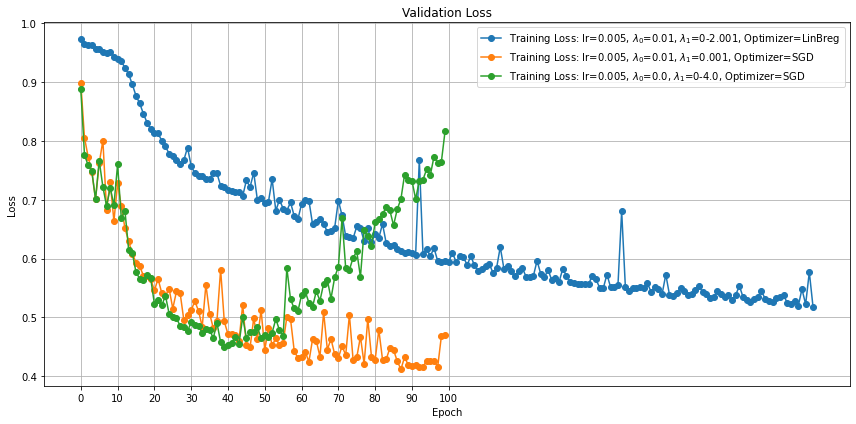

Plotting metrics for: LR=0.005, L0=0.01, L1=0-2.001, OPT=LinBreg
Plotting metrics for: LR=0.005, L0=0.01, L1=0.001, OPT=SGD
Plotting metrics for: LR=0.005, L0=0.0, L1=0-4.0, OPT=SGD


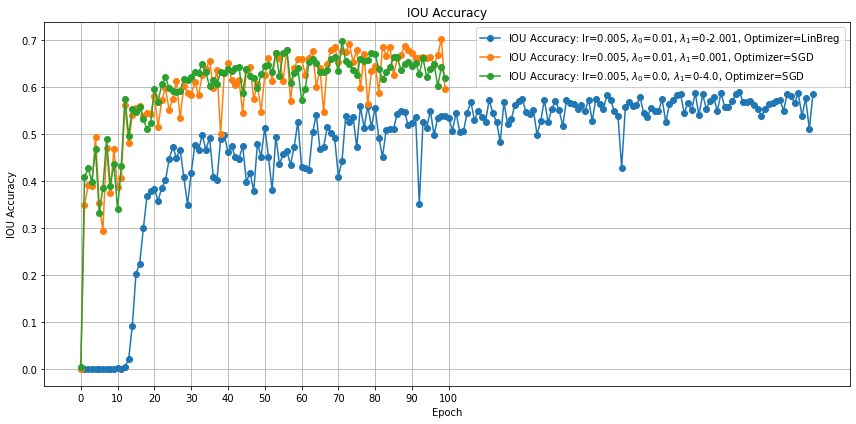

Plotting metrics for: LR=0.005, L0=0.01, L1=0-2.001, OPT=LinBreg
Plotting metrics for: LR=0.005, L0=0.01, L1=0.001, OPT=SGD
Plotting metrics for: LR=0.005, L0=0.0, L1=0-4.0, OPT=SGD


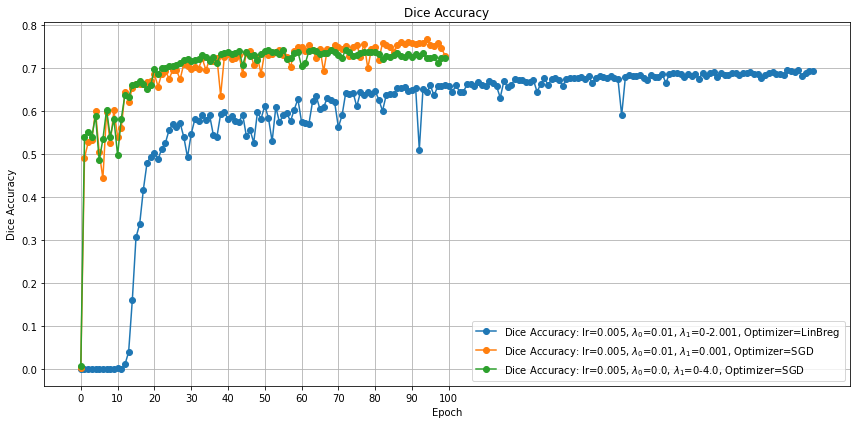

Plotting metrics for: LR=0.005, L0=0.01, L1=0-2.001, OPT=LinBreg
Plotting metrics for: LR=0.005, L0=0.01, L1=0.001, OPT=SGD
Plotting metrics for: LR=0.005, L0=0.0, L1=0-4.0, OPT=SGD


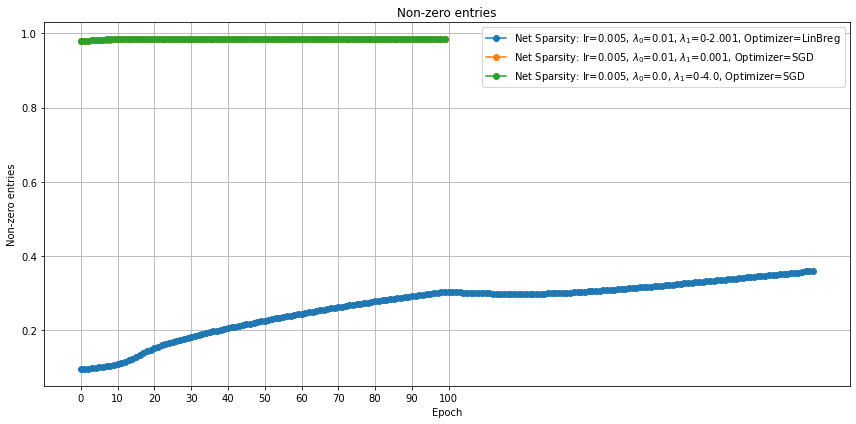

In [29]:
import os
import csv
import matplotlib.pyplot as plt

# Function to read CSV file into a dictionary
def read_csv_to_dict(file_path):
    data = {}
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        for row in reader:
            epoch = int(row[0])
            value = float(row[1])
            data[epoch] = value
    return data

# Function to read node sparsity CSV file into a dictionary
def read_node_sparsity_csv(file_path):
    data = {}
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        node_indices = [header.split('_')[-1] for header in headers[1:]]  # Extract node indices from headers
        for row in reader:
            epoch = int(row[0])
            values = list(map(float, row[1:]))
            for idx, node_index in enumerate(node_indices):
                if node_index not in data:
                    data[node_index] = []
                data[node_index].append(values[idx])
    return data

# Function to plot training loss
def plot_training_loss(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    loss_path = os.path.join(save_path, "validation_loss.csv")
    loss_data = read_csv_to_dict(loss_path)
    
    epochs = list(loss_data.keys())
    loss_values = list(loss_data.values())
    
    ax.plot(epochs, loss_values, marker='o', linestyle='-', label=f'Training Loss: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    return epochs

# Function to plot IOU accuracy
def plot_iou_accuracy(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    iou_path = os.path.join(save_path, "iou_accuracy.csv")
    iou_data = read_csv_to_dict(iou_path)
    
    epochs = list(iou_data.keys())
    iou_values = list(iou_data.values())
    
    ax.plot(epochs, iou_values, marker='o', linestyle='-', label=f'IOU Accuracy: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    return epochs

# Function to plot Dice accuracy
def plot_dice_accuracy(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    dice_path = os.path.join(save_path, "dice_accuracy.csv")
    dice_data = read_csv_to_dict(dice_path)
    
    epochs = list(dice_data.keys())
    dice_values = list(dice_data.values())
    
    ax.plot(epochs, dice_values, marker='o', linestyle='-', label=f'Dice Accuracy: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    return epochs

# Function to plot net sparsity
def plot_net_sparsity(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    net_path = os.path.join(save_path, "net_sparsity.csv")
    net_data = read_csv_to_dict(net_path)
    
    epochs = list(net_data.keys())
    net_values = list(net_data.values())
    
    ax.plot(epochs, net_values, marker='o', linestyle='-', label=f'Net Sparsity: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    return epochs

# Function to create and display a plot
def create_and_display_plot(plot_function, title, ylabel, base_path):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.grid(True)
    
    subdirectories = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]
    
    for subdir in subdirectories:
        subdir_path = os.path.join(base_path, subdir)
        
        # Parse the directory name to extract parameters
        params = subdir.split('_')
        formatted_lr = params[1]
        formatted_lamda0 = params[3]
        formatted_lamda1 = params[5]
        formatted_opt = params[6]
        
        print(f"Plotting metrics for: LR={formatted_lr}, L0={formatted_lamda0}, L1={formatted_lamda1}, OPT={formatted_opt}")
        
        epochs = plot_function(ax, subdir_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.set_xticks(range(0, len(epochs) + 1, 10))  # Set x-axis ticks for every 10 epochs
    ax.set_xticklabels(range(0, len(epochs) + 1, 10))  # Set x-axis tick labels for every 10 epochs
    
    plt.tight_layout()
    plt.show()

# Example usage
save_path = 'result'
create_and_display_plot(plot_training_loss, 'Validation Loss', 'Loss', save_path)
create_and_display_plot(plot_iou_accuracy, 'IOU Accuracy', 'IOU Accuracy', save_path)
create_and_display_plot(plot_dice_accuracy, 'Dice Accuracy', 'Dice Accuracy', save_path)
create_and_display_plot(plot_net_sparsity, 'Non-zero entries', 'Non-zero entries', save_path)



Epoch: 00, IoU: 0.0704, Net: 0.4586, Node: 0.2500, 0.8125, 0.7500, 0.9375, 0.9688, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 1.0000, 1.0000, 0.8125, 1.0000


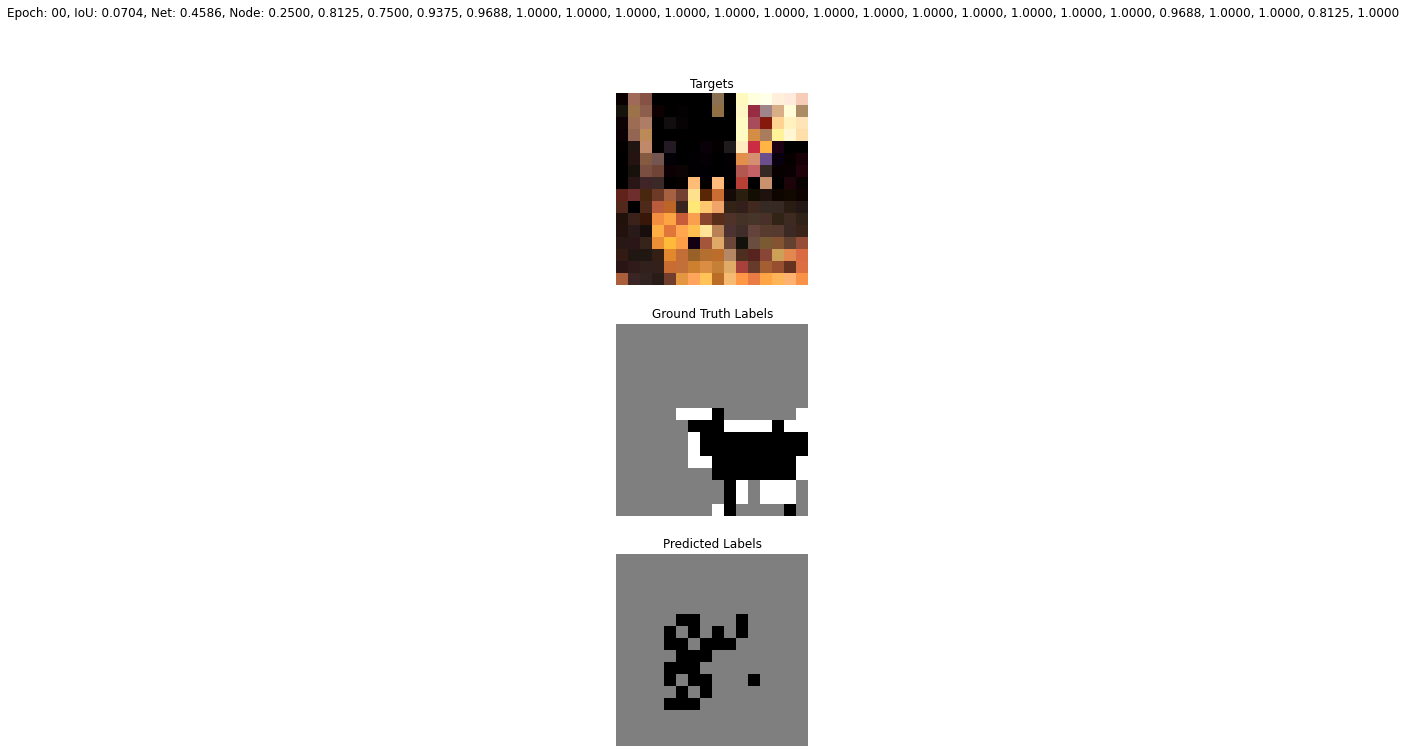

In [30]:
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(model, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

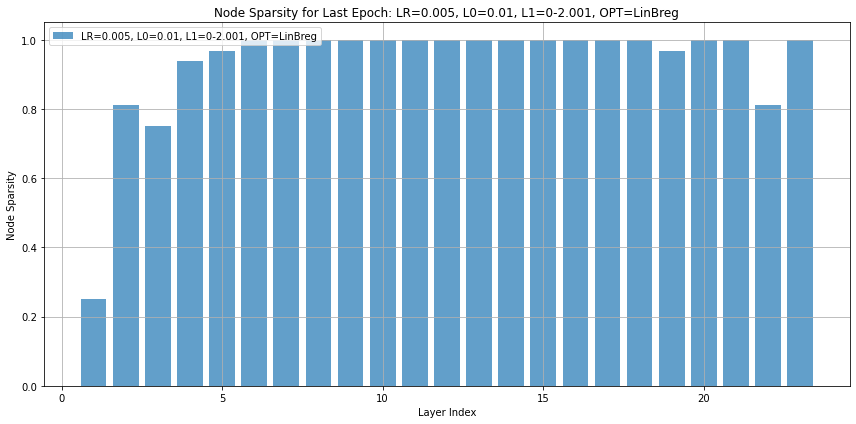

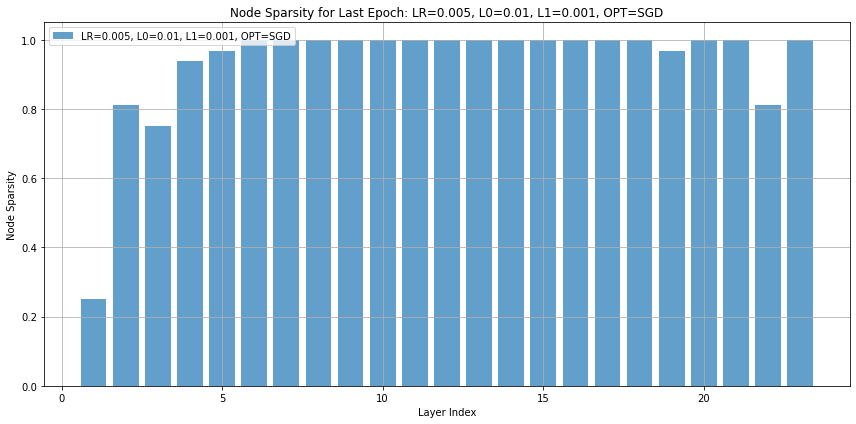

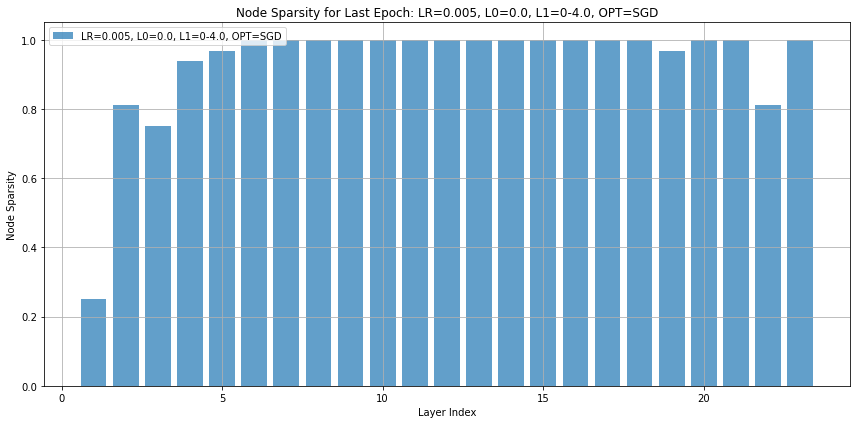

In [31]:
import os
import csv
import matplotlib.pyplot as plt

# Function to read node sparsity CSV file and extract the last epoch values
def read_last_epoch_node_sparsity(file_path):
    data = []
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        for row in reader:
            epoch = int(row[0])
            values = list(map(float, row[1:]))
            data.append(values)
    return data[-1]  # Return the values of the last epoch

# Function to plot the node sparsity for the last epoch from multiple directories in separate figures
def plot_node_sparsity_multiple_directories(base_path):
    subdirectories = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]
    
    for subdir in subdirectories:
        subdir_path = os.path.join(base_path, subdir)
        node_sparsity_path = os.path.join(subdir_path, "node_sparsity.csv")
        
        # Check if node_sparsity.csv exists in the directory
        if os.path.exists(node_sparsity_path):
            node_sparsity = read_last_epoch_node_sparsity(node_sparsity_path)
            layer_indices = range(1, len(node_sparsity) + 1)
            
            # Parse the directory name to extract parameters
            params = subdir.split('_')
            formatted_lr = params[1]
            formatted_lamda0 = params[3]
            formatted_lamda1 = params[5]
            formatted_opt = params[6]
            
            label = f'LR={formatted_lr}, L0={formatted_lamda0}, L1={formatted_lamda1}, OPT={formatted_opt}'
            
            # Create a new figure for each directory
            plt.figure(figsize=(12, 6))
            plt.bar(layer_indices, node_sparsity, label=label, alpha=0.7)
            plt.xlabel('Layer Index')
            plt.ylabel('Node Sparsity')
            plt.title(f'Node Sparsity for Last Epoch: {label}')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            
            # Save the plot as an image file
            output_path = os.path.join(subdir_path, 'node_sparsity_bar_chart.png')
            plt.savefig(output_path)
            plt.show()

# Example usage
base_path = 'result'
plot_node_sparsity_multiple_directories(base_path)




# Evaluation